## Formation Clustering
Section 4.1.3 in the paper

In [1]:
import os
wd = os.path.normpath(os.getcwd() + '/..')
os.chdir(wd)
os.getcwd()

'C:\\Users\\Fitogether\\Workspace\\research-footballcpd'

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
from collections import Counter
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams["font.family"] = 'Arial'
plt.rcParams["font.size"] = 15

### Calculating the pairwise distances between formation graphs

In [3]:
form_periods = pd.read_pickle('data/form_periods.pkl')
form_periods

,activity_id,session,form_period,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,0,1,1,hidden,hidden,2940.0,"[[-1356.0, 800.0], [-657.0, 83.0], [428.0, 606...","[[0.0, 0.932, 0.44, 0.995, 0.012, 0.108, 0.03,...",14,433
1,0,2,2,hidden,hidden,2880.0,"[[-1407.0, 395.0], [-469.0, -16.0], [531.0, 77...","[[0.0, 0.889, 0.408, 0.992, 0.019, 0.157, 0.01...",14,433
2,1,1,1,hidden,hidden,2760.0,"[[-1309.0, 68.0], [-343.0, 2320.0], [-1152.0, ...","[[0.0, 0.373, 0.973, 0.94, 0.073, 0.015, 0.973...",-1,others
3,1,2,2,hidden,hidden,2880.0,"[[-1592.0, -58.0], [64.0, 2090.0], [-1399.0, -...","[[0.0, 0.207, 0.995, 0.956, 0.042, 0.01, 0.924...",2,4132
4,2,1,1,hidden,hidden,2820.0,"[[-590.0, 1355.0], [-109.0, -558.0], [1309.0, ...","[[0.0, 0.11, 0.027, 0.986, 0.255, 0.372, 0.009...",21,442
...,...,...,...,...,...,...,...,...,...,...
861,454,2,2,hidden,hidden,3000.0,"[[-1089.0, -647.0], [-639.0, -189.0], [1091.0,...","[[0.0, 0.967, 0.001, 0.425, 0.335, 0.145, 0.02...",22,4231
862,455,1,1,hidden,hidden,460.0,"[[-1141.0, 1175.0], [-242.0, -603.0], [-1025.0...","[[0.0, 0.292, 0.307, 1.0, 0.343, 0.007, 0.686,...",2,4132
863,455,1,2,hidden,hidden,2300.0,"[[-1318.0, 1242.0], [-376.0, -285.0], [-1222.0...","[[0.0, 0.617, 0.278, 0.987, 0.473, 0.005, 0.51...",2,4132
864,455,2,3,hidden,hidden,2940.0,"[[-1592.0, 709.0], [524.0, -797.0], [-1014.0, ...","[[0.0, 0.094, 0.369, 0.979, 0.406, 0.008, 0.85...",14,433


In [4]:
def delaunay_dist(form1, form2):
    cost_mat = distance_matrix(form1['coords'], form2['coords'])
    _, perm = linear_sum_assignment(cost_mat)
    edge_mat1 = form1['edge_mat']
    edge_mat2 = form2['edge_mat'][perm][:, perm]
    return np.abs(edge_mat1 - edge_mat2).sum()

In [5]:
n = len(form_periods)
dist_mat = np.zeros((n, n))

for i, j in tqdm(itertools.product(range(n), range(n))):
    if i >= j:
        continue
        
    form1 = form_periods.iloc[i]
    form2 = form_periods.iloc[j]
    assign_cost_mat = distance_matrix(form1['coords'], form2['coords'])
    _, perm = linear_sum_assignment(assign_cost_mat)
    
    edge_mat1 = form1['edge_mat']
    edge_mat2 = form2['edge_mat'][perm][:, perm]
    dist_mat[i, j] = np.abs(edge_mat1 - edge_mat2).sum()

dist_mat = dist_mat + dist_mat.T
dist_mat

749956it [03:06, 4020.30it/s] 


array([[ 0.   ,  4.062, 13.554, ..., 17.358,  5.592,  5.8  ],
       [ 4.062,  0.   , 12.024, ..., 10.08 ,  4.238,  5.066],
       [13.554, 12.024,  0.   , ..., 11.976, 12.222, 16.99 ],
       ...,
       [17.358, 10.08 , 11.976, ...,  0.   , 10.11 ,  9.886],
       [ 5.592,  4.238, 12.222, ..., 10.11 ,  0.   ,  6.248],
       [ 5.8  ,  5.066, 16.99 , ...,  9.886,  6.248,  0.   ]])

In [6]:
pd.DataFrame(dist_mat).to_csv('data/form_dist_mat.csv', header=False, index=False)

### Initial clustering based on the distance matrix

In [ ]:
dist_mat = pd.read_csv('data/form_dist_mat.csv', header=None).values
dist_mat

array([[ 0.   ,  4.062, 13.554, ..., 17.358,  5.592,  5.8  ],
       [ 4.062,  0.   , 12.024, ..., 10.08 ,  4.238,  5.066],
       [13.554, 12.024,  0.   , ..., 11.976, 12.222, 16.99 ],
       ...,
       [17.358, 10.08 , 11.976, ...,  0.   , 10.11 ,  9.886],
       [ 5.592,  4.238, 12.222, ..., 10.11 ,  0.   ,  6.248],
       [ 5.8  ,  5.066, 16.99 , ...,  9.886,  6.248,  0.   ]])

In [8]:
n_clusters = 18
model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
model = model.fit(dist_mat)
counter = Counter(model.labels_)
outliers = []
for cluster, count in counter.items():
    if count < 15:
        outliers.append(cluster)
form_periods['cluster'] = np.where(np.isin(model.labels_, outliers), -1, model.labels_)
counts = form_periods['cluster'].value_counts()
counts

 3     341
 0     177
 14    143
 17    103
 2      61
-1      41
Name: cluster, dtype: int64

In [9]:
def visualize_cluster(form_periods, group, group_label='cluster'):
    coords_series = form_periods[form_periods[group_label] == group]['coords']
    
    coords_df = pd.DataFrame(np.vstack(coords_series.values))
    coloring_model = AgglomerativeClustering(n_clusters=10).fit(coords_df.values)
    coords_df['color'] = coloring_model.labels_
    mean_coords = coords_df.groupby('color').mean().values
    
    for i in range(3):
        coords_list = []
        for coords in coords_series:
            assign_cost_mat = distance_matrix(mean_coords, coords)
            _, perm = linear_sum_assignment(assign_cost_mat)
            coords_list.append(coords[perm])
        coords_aligned = np.stack(coords_list)
        mean_coords = coords_aligned.mean(axis=0)

    plt.figure()
    for r in range(10):
        plt.scatter(coords_aligned[:, r, 0], coords_aligned[:, r, 1], s=100, alpha=0.5)
    xlim = 3000
    ylim = 3000
    plt.xlim(-xlim, xlim)
    plt.ylim(-ylim, ylim)
    plt.vlines([-xlim, 0, xlim], ymin=-ylim, ymax=ylim, color='k', zorder=0)
    plt.hlines([-ylim, ylim], xmin=-xlim, xmax=xlim, color='k', zorder=0)
    plt.axis('off')

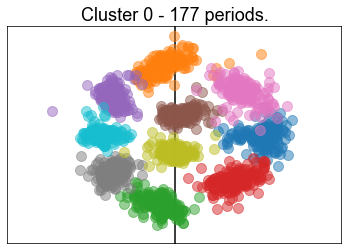

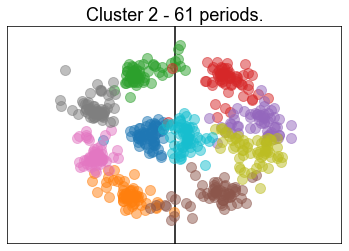

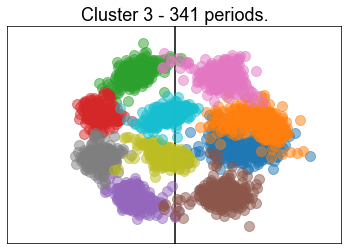

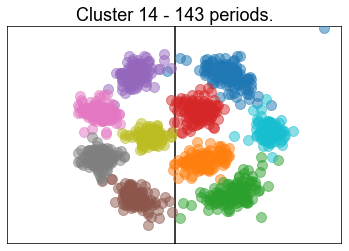

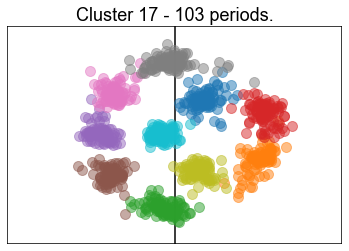

In [10]:
clusters = [c for c in np.sort(form_periods['cluster'].unique()) if c != -1]
for c in clusters:
    visualize_cluster(form_periods, c)
    plt.savefig(f'img/clustering_c{c}.pdf', bbox_inches='tight')
    plt.title(f'Cluster {c} - {counts[c]} periods.')

In [11]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, color_threshold=0, **kwargs)
    ax = plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=15)

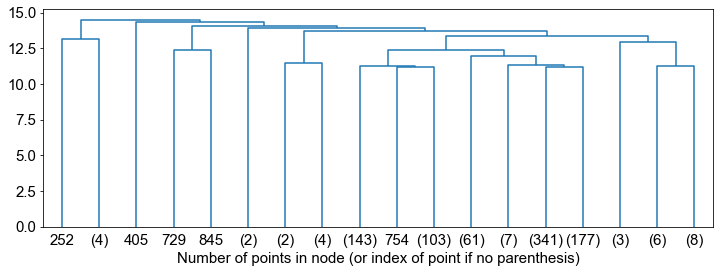

In [12]:
plt.figure(figsize=(12, 4))
model = AgglomerativeClustering(
    n_clusters=None, affinity='precomputed', linkage='average', distance_threshold=0
)
model.fit(dist_mat)
plot_dendrogram(model, truncate_mode='lastp', p=n_clusters)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

### Further clustering to separate "4-4-2" and "4-2-3-1"
Since two formation ("4-4-2" and "4-2-3-1") seem to be mixed in cluster 3, we further split the cluster 3 to separate them

In [ ]:
cluster_idxs = form_periods[form_periods['cluster'] == 3].index
dist_mat_cluster = dist_mat[cluster_idxs][:, cluster_idxs]
dist_mat_cluster.shape

(341, 341)

In [ ]:
submodel = AgglomerativeClustering(n_clusters=15, affinity='precomputed', linkage='average')
submodel = submodel.fit(dist_mat_cluster)
counter = Counter(submodel.labels_)
outliers = []
for cluster, count in counter.items():
    if count < 15:
        outliers.append(cluster)
form_periods.loc[cluster_idxs, 'cluster'] = np.where(
    np.isin(submodel.labels_, outliers), -1, submodel.labels_ + n_clusters
)
counts = form_periods.loc[cluster_idxs, 'cluster'].value_counts()
counts

 21    140
 20     81
 22     57
-1      33
 27     30
Name: cluster, dtype: int64

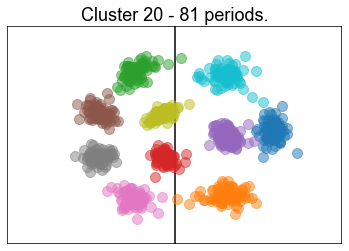

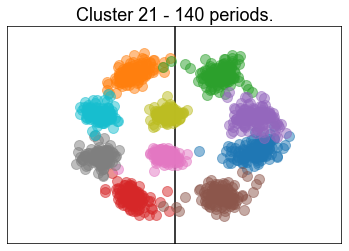

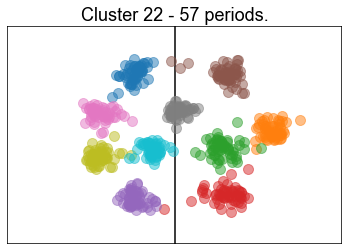

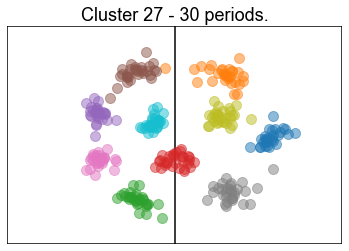

In [15]:
clusters = [c for c in np.sort(form_periods.loc[cluster_idxs, 'cluster'].unique()) if c != -1]
for c in clusters:
    visualize_cluster(form_periods, c)
    plt.savefig(f'img/clustering_c{c}.pdf', bbox_inches='tight')
    plt.title(f'Cluster {c} - {counts[c]} periods.')

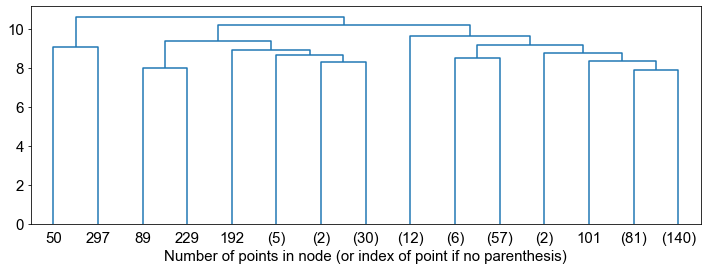

In [16]:
plt.figure(figsize=(12, 4))
submodel = AgglomerativeClustering(
    n_clusters=None, affinity='precomputed', linkage='average', distance_threshold=0
)
submodel.fit(dist_mat_c3)
plot_dendrogram(submodel, truncate_mode='lastp', p=15)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

### Assigning a formation label per cluster

In [17]:
clus_to_form = {0: '343', 17: '352', 14: '433', 2: '4132', 21: '442',
                20: '4231', 22: '4231', 27: '4231', -1: 'others'}
form_periods['formation'] = form_periods['cluster'].apply(lambda x: clus_to_form[x])
form_periods.to_pickle('data/form_periods.pkl')
form_periods

,activity_id,session,form_period,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,0,1,1,hidden,hidden,2940.0,"[[-1356.0, 800.0], [-657.0, 83.0], [428.0, 606...","[[0.0, 0.932, 0.44, 0.995, 0.012, 0.108, 0.03,...",14,433
1,0,2,2,hidden,hidden,2880.0,"[[-1407.0, 395.0], [-469.0, -16.0], [531.0, 77...","[[0.0, 0.889, 0.408, 0.992, 0.019, 0.157, 0.01...",14,433
2,1,1,1,hidden,hidden,2760.0,"[[-1309.0, 68.0], [-343.0, 2320.0], [-1152.0, ...","[[0.0, 0.373, 0.973, 0.94, 0.073, 0.015, 0.973...",-1,others
3,1,2,2,hidden,hidden,2880.0,"[[-1592.0, -58.0], [64.0, 2090.0], [-1399.0, -...","[[0.0, 0.207, 0.995, 0.956, 0.042, 0.01, 0.924...",2,4132
4,2,1,1,hidden,hidden,2820.0,"[[-590.0, 1355.0], [-109.0, -558.0], [1309.0, ...","[[0.0, 0.11, 0.027, 0.986, 0.255, 0.372, 0.009...",21,442
...,...,...,...,...,...,...,...,...,...,...
861,454,2,2,hidden,hidden,3000.0,"[[-1089.0, -647.0], [-639.0, -189.0], [1091.0,...","[[0.0, 0.967, 0.001, 0.425, 0.335, 0.145, 0.02...",22,4231
862,455,1,1,hidden,hidden,460.0,"[[-1141.0, 1175.0], [-242.0, -603.0], [-1025.0...","[[0.0, 0.292, 0.307, 1.0, 0.343, 0.007, 0.686,...",2,4132
863,455,1,2,hidden,hidden,2300.0,"[[-1318.0, 1242.0], [-376.0, -285.0], [-1222.0...","[[0.0, 0.617, 0.278, 0.987, 0.473, 0.005, 0.51...",2,4132
864,455,2,3,hidden,hidden,2940.0,"[[-1592.0, 709.0], [524.0, -797.0], [-1014.0, ...","[[0.0, 0.094, 0.369, 0.979, 0.406, 0.008, 0.85...",14,433


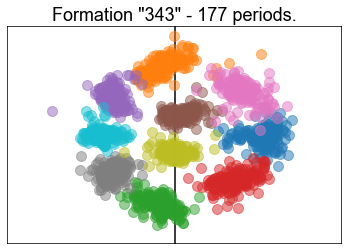

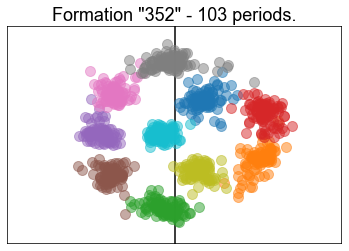

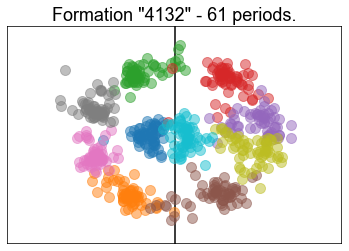

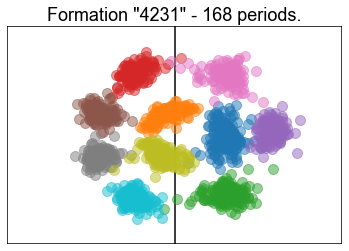

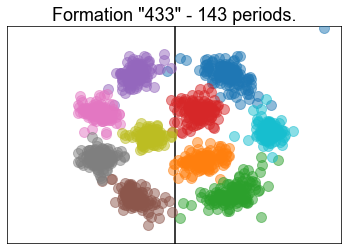

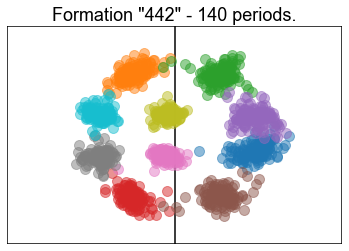

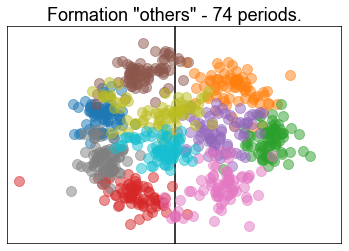

In [18]:
counts = form_periods['formation'].value_counts()
for f in np.sort(form_periods['formation'].unique()):
    visualize_cluster(form_periods, f, group_label='formation')
    plt.savefig(f'img/clustering_{f}.pdf', bbox_inches='tight')
    plt.title(f'Formation "{f}" - {counts[f]} periods.')

In [19]:
total_dur = form_periods['duration'].sum()
form_durs = form_periods.groupby('formation')['duration'].sum()

counts = form_periods['formation'].value_counts()
form_props = (form_durs / total_dur).round(4)
form_mean_durs = (form_durs / form_periods['formation'].value_counts()).round(1)

counts.name = 'count'
form_props.name = 'proportion'
form_mean_durs.name = 'mean_dur'

pd.concat([counts, form_props, form_mean_durs], axis=1)

,count,proportion,mean_dur
343,177,0.2103,2770.4
4231,168,0.2001,2777.3
433,143,0.1669,2722.0
442,140,0.1670,2782.6
352,103,0.1185,2683.5
others,74,0.0667,2101.2
4132,61,0.0706,2698.5
